In [2]:
import gym
import d4rl # Import required to register environments
# import time 
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
class TensorPairDataset(Dataset):
    def __init__(self, tensor1, tensor2):
        assert len(tensor1) == len(tensor2), "Tensors must have the same length"
        self.tensor1 = tensor1
        self.tensor2 = tensor2

    def __len__(self):
        return len(self.tensor1)

    def __getitem__(self, idx):
        return self.tensor1[idx], self.tensor2[idx]

In [43]:
env = gym.make("hopper-expert-v0")
dataset = env.get_dataset()

/home/utsab/miniconda3/envs/IRL_AGV/lib/python3.10/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment hopper-expert-v0 is out of date. You should consider upgrading to version `v2` with the environment ID `hopper-expert-v2`.
  logger.warn(


load datafile: 100%|██████████████████████████████| 5/5 [00:00<00:00, 21.02it/s]


In [2]:
len(dataset['observations'])

NameError: name 'dataset' is not defined

In [1]:
dataset['rewards'].sum()

NameError: name 'dataset' is not defined

In [45]:
observations = torch.tensor(dataset['observations'])[:1000000]
mean = observations.mean(dim=0)
std = observations.std(dim=0)
observations = (observations - mean)/std
actions = torch.tensor(dataset['actions'])[:1000000]
data = TensorPairDataset(observations,actions)

In [46]:
observations

tensor([[-0.7753,  0.7459,  2.2722,  ...,  0.0356,  0.0036, -0.0103],
        [-0.7777,  0.7685,  2.2912,  ...,  0.2677, -0.2552,  0.1919],
        [-0.7840,  0.7361,  2.3042,  ...,  0.1355, -0.6216,  0.2170],
        ...,
        [ 1.3769, -0.6681, -0.4511,  ..., -0.1312,  0.5528,  1.6705],
        [ 1.3593, -0.6443, -0.4527,  ...,  0.1600,  0.4813,  1.0665],
        [ 1.3460, -0.5772, -0.4318,  ...,  0.4269,  0.5215,  0.2349]])

In [47]:
env.reward_range

(-inf, inf)

In [48]:
env.reset()

array([ 1.25029785e+00,  2.07560937e-03,  4.90098125e-03, -3.91986586e-03,
        3.24570755e-05, -2.19936342e-03,  2.01673521e-03,  4.24321134e-03,
        3.26184557e-03, -5.38502643e-04,  1.25899667e-03])

In [49]:
train_ds, test_ds = random_split(data,[900000,100000])


In [50]:
batch_size=256

In [51]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, 2*batch_size, num_workers=4, pin_memory=True)

In [52]:
def accuracy(loss):
    return torch.exp(-loss)

In [53]:
def normalize(input):
    mean = input.mean(dim=0)
    std = input.std(dim=0)
    input = (input - mean)/std
    return input

class Normalize(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        mean = input.mean(dim=0)
        std = input.std(dim=0)
        input = (input - mean)/std
        return input        

In [54]:
class B_Network(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.network = nn.Sequential(nn.Linear(input_size,64),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(64),
                                     nn.Linear(64,24),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(24),
                                     nn.Linear(24,output_size),
                                     nn.Tanh())
    def forward(self,state):
            return self.network(state)
    
    def training_step(self, batch):
        state, action = batch 
        out = self(state)                  # Generate predictions
        loss = F.mse_loss(out, action) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        state, action = batch 
        out = self(state)                    # Generate predictions
        loss = F.mse_loss(out, action)   # Calculate loss
        acc = accuracy(loss)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [55]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [56]:
device = get_default_device()
device

device(type='cuda')

In [57]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [58]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [59]:
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [60]:
len(train_loader)

3516

In [61]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, max_lr, model, train_loader, val_loader,weight_decay=0,grad_clip=None, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    
    history = []
    optimizer = opt_func(model.parameters(), max_lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            # sched.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [62]:
# Model (on GPU)
model = B_Network(11,3)

to_device(model, device)

B_Network(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=24, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=24, out_features=3, bias=True)
    (7): Tanh()
  )
)

In [63]:
to_device(model, device)

B_Network(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=24, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=24, out_features=3, bias=True)
    (7): Tanh()
  )
)

In [64]:
observations
model.train()

B_Network(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=24, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=24, out_features=3, bias=True)
    (7): Tanh()
  )
)

In [65]:
history = [evaluate(model, train_loader)]
history

[{'val_loss': 0.6044708490371704, 'val_acc': 0.5465126633644104}]

In [66]:
grad_clip = 0.01
weight_decay = 0.0005
max_lr=(batch_size/32.)*0.01
epochs=30

In [67]:
history += fit(epochs, max_lr, model, train_loader, test_loader,grad_clip=None,weight_decay=weight_decay)

Epoch [0], val_loss: 0.0964, val_acc: 0.9081
Epoch [1], val_loss: 0.0934, val_acc: 0.9108
Epoch [2], val_loss: 0.0863, val_acc: 0.9173
Epoch [3], val_loss: 0.0846, val_acc: 0.9189
Epoch [4], val_loss: 0.0834, val_acc: 0.9200
Epoch [5], val_loss: 0.0816, val_acc: 0.9216
Epoch [6], val_loss: 0.0812, val_acc: 0.9220
Epoch [7], val_loss: 0.0806, val_acc: 0.9226
Epoch [8], val_loss: 0.0794, val_acc: 0.9237
Epoch [9], val_loss: 0.0788, val_acc: 0.9242
Epoch [10], val_loss: 0.0789, val_acc: 0.9241
Epoch [11], val_loss: 0.0788, val_acc: 0.9242
Epoch [12], val_loss: 0.0783, val_acc: 0.9247
Epoch [13], val_loss: 0.0777, val_acc: 0.9252
Epoch [14], val_loss: 0.0777, val_acc: 0.9253
Epoch [15], val_loss: 0.0775, val_acc: 0.9255
Epoch [16], val_loss: 0.0765, val_acc: 0.9264
Epoch [17], val_loss: 0.0766, val_acc: 0.9262
Epoch [18], val_loss: 0.0773, val_acc: 0.9257
Epoch [19], val_loss: 0.0771, val_acc: 0.9258
Epoch [20], val_loss: 0.0768, val_acc: 0.9261
Epoch [21], val_loss: 0.0764, val_acc: 0.926

In [68]:
def plot_losses(history):
    train_losses = [x.get('val_acc') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    plt.show()

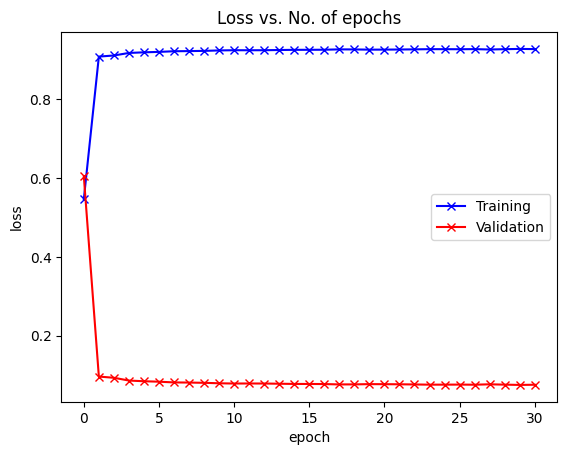

In [69]:
plot_losses(history)

In [74]:
@torch.no_grad

def test(model,episodes):
    env = gym.make("hopper-medium-v0")
    state = env.reset()
    state = torch.from_numpy(state).float().reshape(1,11)
    # print(state)
    total_reward=0
    model.eval()
    for ep in range(episodes):
        action = model(state).reshape(3)
        # print(action)
        # print(action)
        new_state, reward, done, info= env.step(action.numpy())
        # print(env.step(action))
        total_reward+=reward
        # 
        if done:
            # print(f"{ep} Total reward:",total_reward)
            break
        state = torch.from_numpy(new_state).float().reshape(1,11)
    # print(total_reward)
        img=env.render('rgb_array')
        
    env.close()
    return total_reward

In [75]:
model.eval()

for module in model.modules():
    if isinstance(module, nn.BatchNorm1d):
        print(f"Training mode: {module.training}")

Training mode: False
Training mode: False


cpu


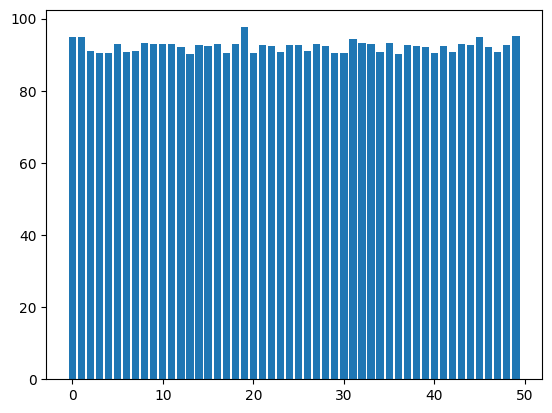

In [80]:
model.to(torch.device('cpu'))
print(next(model.parameters()).device)
test_history=[]
for i in range(50):
    # print("=====================")
    test_history.append(test(model,1000))
plt.bar(range(len(test_history)),test_history)
plt.show()

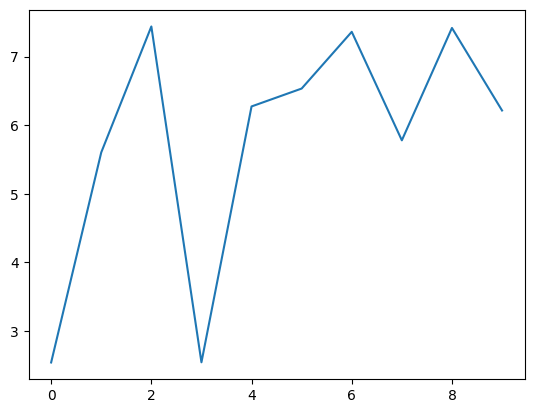

In [155]:
env.action_space

Box(-1.0, 1.0, (2,), float32)

In [156]:
env.step((0.3,0.5))

(array([1.96259572, 2.05850765, 0.12681006, 0.24620351]), 0.0, False, {})

In [157]:
gym.envs.registry.all()

ValuesView(├──CartPole: [ v0, v1 ]
├──MountainCar: [ v0 ]
├──MountainCarContinuous: [ v0 ]
├──Pendulum: [ v1 ]
├──Acrobot: [ v1 ]
├──LunarLander: [ v2 ]
├──LunarLanderContinuous: [ v2 ]
├──BipedalWalker: [ v3 ]
├──BipedalWalkerHardcore: [ v3 ]
├──CarRacing: [ v1 ]
├──Blackjack: [ v1 ]
├──FrozenLake: [ v1 ]
├──FrozenLake8x8: [ v1 ]
├──CliffWalking: [ v0 ]
├──Taxi: [ v3 ]
├──Reacher: [ v2 ]
├──Pusher: [ v2 ]
├──InvertedPendulum: [ v2 ]
├──InvertedDoublePendulum: [ v2 ]
├──HalfCheetah: [ v2, v3 ]
├──Hopper: [ v2, v3 ]
├──Swimmer: [ v2, v3 ]
├──Walker2d: [ v2, v3 ]
├──Ant: [ v2, v3 ]
├──Humanoid: [ v2, v3 ]
├──HumanoidStandup: [ v2 ]
├──antmaze-umaze: [ v0, v1, v2 ]
├──antmaze-umaze-diverse: [ v0, v1, v2 ]
├──antmaze-medium-play: [ v0, v1, v2 ]
├──antmaze-medium-diverse: [ v0, v1, v2 ]
├──antmaze-large-diverse: [ v0, v1, v2 ]
├──antmaze-large-play: [ v0, v1, v2 ]
├──antmaze-eval-umaze: [ v0 ]
├──antmaze-eval-umaze-diverse: [ v0 ]
├──antmaze-eval-medium-play: [ v0 ]
├──antmaze-eval-medium-d